In [1]:
import sys
print(sys.version)

3.5.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:11:22) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:

import numpy as np
import pandas as pd
import matplotlib as mpl
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from concurrent import futures

In [4]:
%matplotlib inline

In [5]:
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

In [6]:
import quandl
quandl.ApiConfig.api_key='mPe9uNzhPMYcN5yoSpsV'

In [7]:
#these stocks have similar market cap this would be my universe of stocks
stock_banking= ['KOTAKBANK','ICICIBANK','AXISBANK','HDFCBANK','INDUSINDBK']
start_date='2013-06-30'
end_date = '2019-06-30'

In [8]:
#need to check whether quandl gives adjusted close data or not
data_test = quandl.get('NSE/KOTAKBANK', trim_start = "2013-06-30", trim_end = "2019-06-30", authtoken='mPe9uNzhPMYcN5yoSpsV')

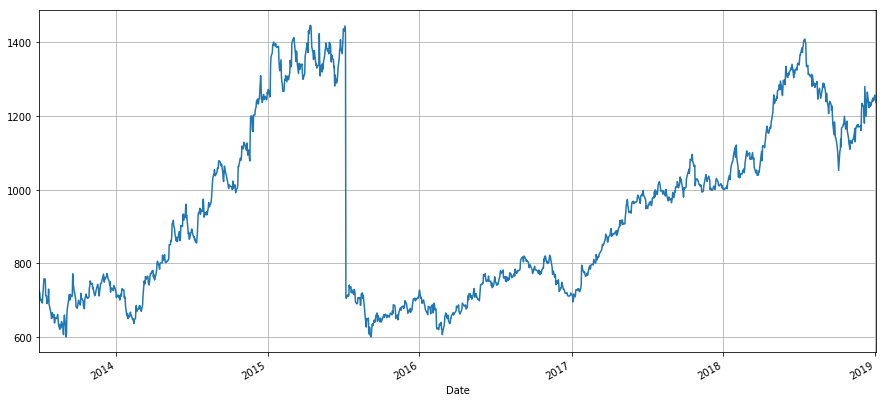

In [9]:
data_test['Close'].plot(figsize=(15,7),grid=True)

In [10]:
#as there is a stock split , I need adjusted close price.Need to download from some other APIs
#using yfinance as hack for downloading from yahoo finance through datareader
import yfinance as yf
yf.pdr_override()

In [11]:
data_test = web.get_data_yahoo("KOTAKBANK.NS", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 downloaded


In [12]:
data_test.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2013-07-01,359.46,361.98,367.50,357.60,361.50,920042
2013-07-02,355.39,357.88,362.27,356.50,360.05,672346
2013-07-03,347.00,349.42,357.52,347.62,355.90,809052
2013-07-04,348.04,349.77,355.40,347.25,351.05,818560
2013-07-05,349.58,351.33,353.88,349.25,353.88,429990


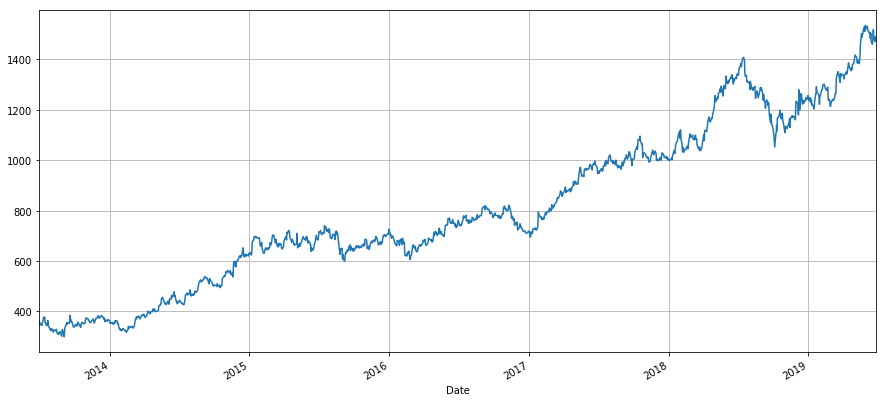

In [13]:
data_test['Adj Close'].plot(figsize=(15,7),grid=True)

In [14]:
df_bank =pd.DataFrame() #initializing a dataframe to store the universe
error_ticker=[]

In [15]:
def prepare_data(stock):
    try:
        print (stock+'.NS')
        df_bank[stock] = web.get_data_yahoo(stock+'.NS', start=start_date, end=end_date)['Adj Close']
        
    except BaseException as e:
        print (e.__doc__)
        print('failed to download %s' %(stock))
        error_ticker.append(stock)

In [16]:
##########TO DO############### 
##add concurrency to download data  ########

In [17]:
for x in stock_banking:
    prepare_data(x)

KOTAKBANK.NS
[*********************100%***********************]  1 of 1 downloaded
ICICIBANK.NS
[*********************100%***********************]  1 of 1 downloaded
AXISBANK.NS
[*********************100%***********************]  1 of 1 downloaded
HDFCBANK.NS
[*********************100%***********************]  1 of 1 downloaded
INDUSINDBK.NS
[*********************100%***********************]  1 of 1 downloaded


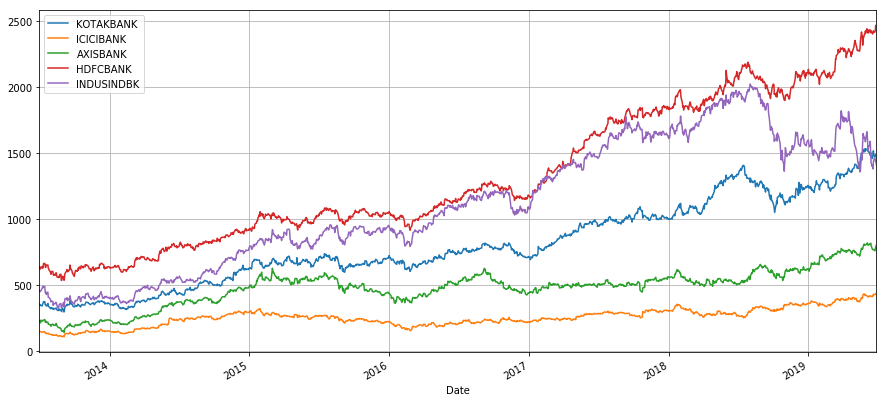

In [18]:
df_bank.plot(figsize=(15,7),grid=True)

In [19]:
#checking for null data
null_data = df_bank[df_bank.isnull().any(axis=1)]
null_data

,KOTAKBANK,ICICIBANK,AXISBANK,HDFCBANK,INDUSINDBK
Date,,,,,


In [20]:
df_bank=df_bank.dropna()
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1474 entries, 2013-07-01 to 2019-06-28
Data columns (total 5 columns):
KOTAKBANK     1474 non-null float64
ICICIBANK     1474 non-null float64
AXISBANK      1474 non-null float64
HDFCBANK      1474 non-null float64
INDUSINDBK    1474 non-null float64
dtypes: float64(5)
memory usage: 69.1 KB


In [21]:
#finding the co integerated pairs by running adf test on the pairs

def find_cointegerated_pairs(dataframe, critical_level , keys):
    n=dataframe.shape[1]
    #pvalue matrix is a n*n matrix having all pvalues from adf test
    pvalue_matrix = np.ones((n,n));
    pairs=[]
    for i in range(n):
        for j in range (i+1,n):
            stock1= dataframe[keys[i]]
            stock2= dataframe[keys[j]]
            result = ts.coint(stock1,stock2)
            pvalue=result[1]
            pvalue_matrix[i][j]=pvalue
            if pvalue <= critical_level:
                pairs.append((keys[i],keys[j],pvalue))
    return pvalue_matrix, pairs

In [22]:
#50-50 split for train and test
split =int(len(df_bank)*0.5)
train_bank_df = df_bank.iloc[:split]
test_bank_df= df_bank.iloc[split:]
pvalue_matrix,pairs = find_cointegerated_pairs(train_bank_df,critical_level=0.05, keys=stock_banking)

In [23]:
pairs
#only two pairs are co integerated

[('KOTAKBANK', 'HDFCBANK', 0.014212047441309186),
 ('HDFCBANK', 'INDUSINDBK', 0.016192175434343738)]

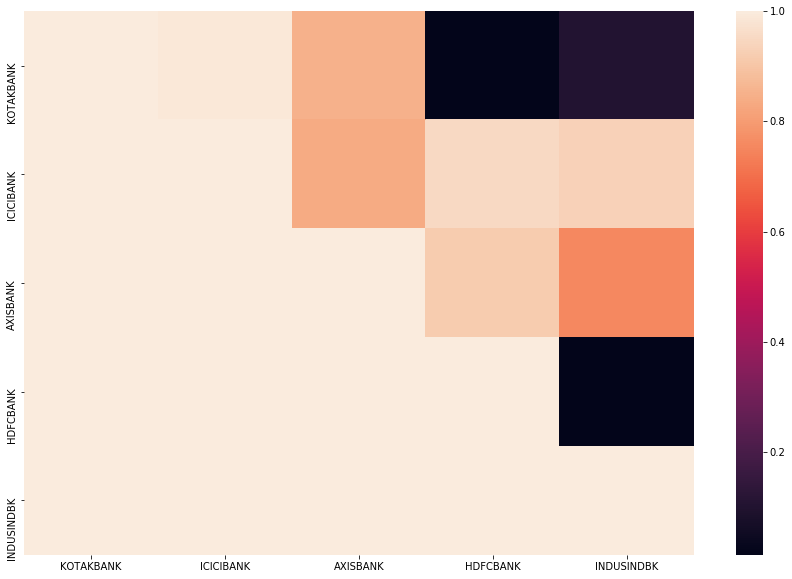

In [24]:
#plotting heat map to show p values of the pairs to visualize the p values
pvalue_matrix_df= pd.DataFrame(pvalue_matrix)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pvalue_matrix_df,xticklabels=stock_banking,yticklabels=stock_banking,ax=ax)

In [25]:
#evenly spaced 10 dates
(df_bank[::len(df_bank)//9].index)

DatetimeIndex(['2013-07-01', '2014-02-25', '2014-10-30', '2015-06-30',
               '2016-02-25', '2016-10-27', '2017-06-23', '2018-02-19',
               '2018-10-17', '2019-06-20'],
              dtype='datetime64[ns]', name='Date', freq=None)

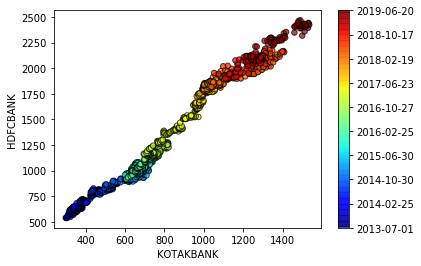

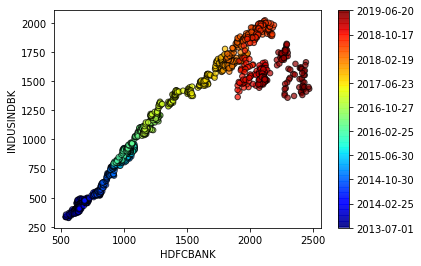

In [26]:
# Plot a pair on scatterplot just to get an idea of a regression fit
def scatterPlot(x,y):
    plt.figure()
    cm=plt.get_cmap('jet')
    colors = np.linspace(0.1,1,len(df_bank))# whole data is required for visualization not just train 
    sc=plt.scatter(x=df_bank[x],y=df_bank[y],s=30,c=colors,cmap=cm,edgecolors='k',alpha=0.7)
    cb=plt.colorbar(sc)
    cb.ax.set_yticklabels([str(p.date()) for p in df_bank[::len(df_bank)//9].index])
    plt.xlabel(x)
    plt.ylabel(y)
    
for x in pairs:
    scatterPlot(x[0],x[1])